In [1]:
import numpy as np
import pandas as  pd

import matplotlib.pyplot as plt
from scipy import  stats
import statsmodels.api as sm  # 统计相关的库
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

## 加载数据

In [2]:
daily300 = pd.read_csv(r'C:\apache\jupyter\data\daily300.csv')
minute300 = pd.read_csv(r'C:\apache\jupyter\data\minute300.csv')
option300 = pd.read_csv(r'C:\apache\jupyter\data\option300.csv')
RisklessReturn = pd.read_csv(r'C:\apache\jupyter\data\RisklessReturn.csv')

daily300.index = pd.to_datetime(daily300['TradeDate'])
minute300.index = pd.to_datetime(minute300['TradeTime'])
option300.index = pd.to_datetime(option300['TradingDate'])
RisklessReturn.index = pd.to_datetime(RisklessReturn['Day'])

## 使用daily300 拟合Garch(1,1)模型

In [3]:
daily300

,TradeDate,Index,ClosePrice,LogReturn
TradeDate,,,,
2017-01-04,2017-01-04,300,3368.31,0.007773
2017-01-05,2017-01-05,300,3367.79,-0.000154
2017-01-06,2017-01-06,300,3347.67,-0.005992
2017-01-09,2017-01-09,300,3363.90,0.004836
2017-01-10,2017-01-10,300,3358.27,-0.001675
...,...,...,...,...
2020-12-25,2020-12-25,300,5042.01,0.008363
2020-12-28,2020-12-28,300,5064.41,0.004433
2020-12-29,2020-12-29,300,5042.94,-0.004248


<AxesSubplot:title={'center':'HS300 Daily Price'}, xlabel='TradeDate'>

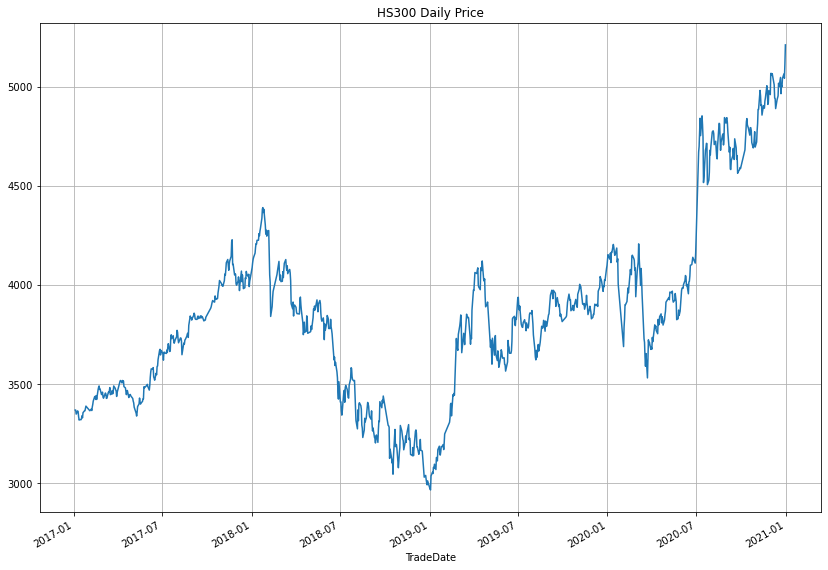

In [4]:
daily300['ClosePrice'].plot(figsize=(14,10),title= 'HS300 Daily Price',grid=True)

<AxesSubplot:title={'center':'Daily Log Return'}, xlabel='TradeDate'>

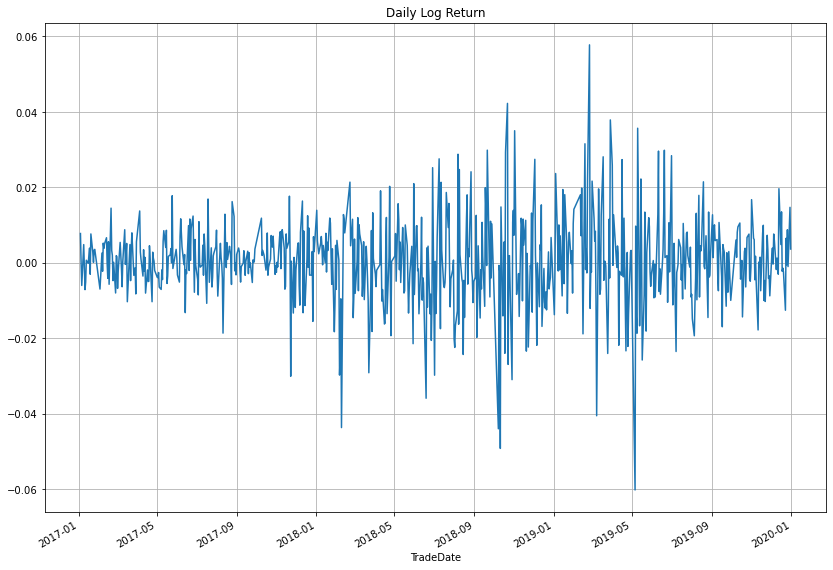

In [5]:
daily300.loc[:'2019-12-31','LogReturn'].plot(figsize=(14,10),title= 'Daily Log Return',grid=True)

###   QQ-plot，平稳性检验，LB TEST，JB TEST

<AxesSubplot:title={'center':'Density Plot'}, ylabel='Density'>

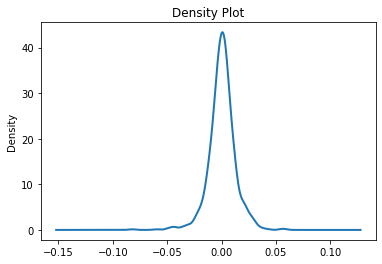

In [6]:
daily300['LogReturn'].plot(kind="density",linewidth=2, title="Density Plot")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


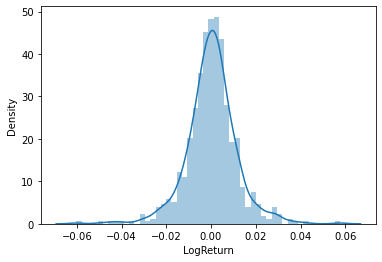

In [7]:
import seaborn as sns

sns.distplot(daily300.loc[:'2019-12-31','LogReturn'])
plt.show()



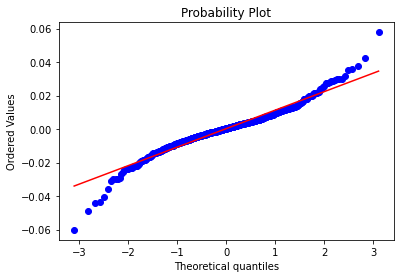

In [8]:
stats.probplot(daily300.loc[:'2019-12-31','LogReturn'], dist="norm", plot=plt) #QQ图显示，对数收益率分布存在尖峰厚尾
plt.show()

In [9]:
#JB TEST 正态性检验 pvalue<0.05 拒绝原假设，样本不服从正态分布
stats.jarque_bera(daily300['LogReturn'])

Jarque_beraResult(statistic=977.5849249921141, pvalue=0.0)

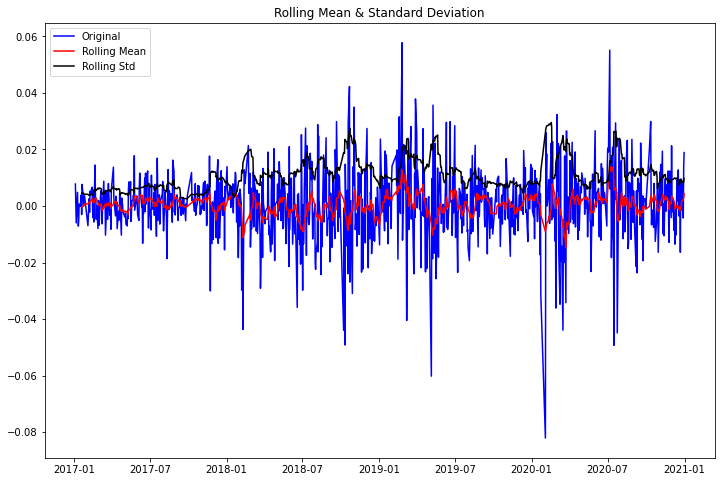

Results of Dickey-Fuller Test:
Test Statistic                -1.175540e+01
p-value                        1.181960e-21
#Lags Used                     7.000000e+00
Number of Observations Used    9.650000e+02
Critical Value (1%)           -3.437145e+00
Critical Value (5%)           -2.864540e+00
Critical Value (10%)          -2.568367e+00
dtype: float64


In [10]:
#平稳性检验
#The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.
#If the pvalue is above a critical size, then we cannot reject that there is a unit root.
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(daily300['LogReturn']) #结果显示Pvalue分别小于各个Critical Value，拒绝原假设，对数收益率序列为平稳序列

In [11]:
#混成检验
m = 25 

acf,q,p = sm.tsa.acf(daily300['LogReturn'],nlags=m,qstat=True,fft=False)  ## 计算自相关系数，LB test 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output #p-value均大于显著性水平0.05。无法拒绝原假设H0，但是观察发现3阶 4阶可用于建模 ARMA(4,3)

,AC,Q,P-value
lag,,,
1.0,0.003359,0.011014,0.916416
2.0,-0.000582,0.011345,0.994344
3.0,0.088192,7.618164,0.054599
4.0,-0.097208,16.869443,0.002049
5.0,-0.003709,16.882926,0.004727
6.0,-0.058081,20.192361,0.002559
7.0,0.035015,21.396415,0.003226
8.0,-0.045840,23.462211,0.002819
9.0,0.025440,24.099140,0.004147


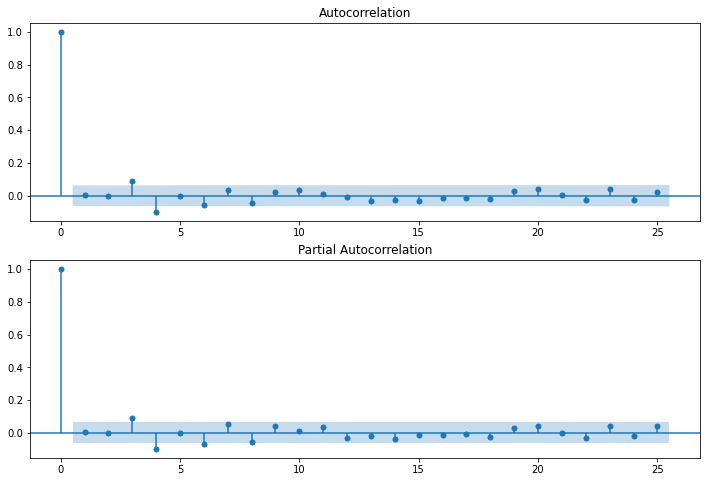

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(daily300['LogReturn'], lags=25,alpha=0.05, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily300['LogReturn'], lags=25,alpha=0.05,ax=ax2)

In [13]:
#建立AR(4)均值方程
model = ARIMA(daily300.loc[:'2019-12-31','LogReturn'], order=(4, 0, 3)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


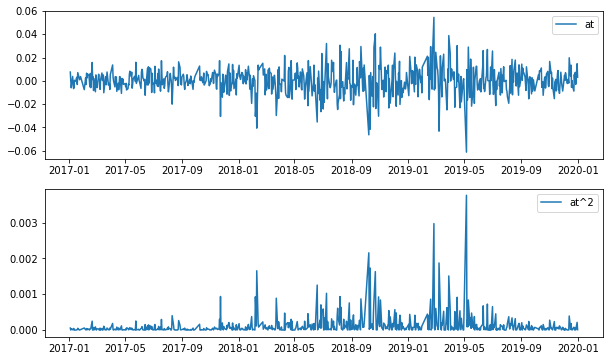

In [14]:
# 计算残差at=rt−mut
#画出残差及残差的平方
at = daily300.loc[:'2019-12-31','LogReturn'] -  model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

In [15]:
#对{a2t}序列进行混成检验 ，残差ARCH效应检验
m = 25 # 检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True,fft=False)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output
#LB TEST结果显示, p-value小于显著性水平0.05，拒绝原假设，即认为残差序列at2具有序列相关性。因此具有ARCH效应。

,AC,Q,P-value
lag,,,
1.0,0.068326,3.421939,6.433541e-02
2.0,0.032640,4.203945,1.222151e-01
3.0,0.103686,12.106067,7.028511e-03
4.0,0.123855,23.396856,1.054842e-04
5.0,0.139958,37.834339,4.073681e-07
6.0,0.066423,41.090689,2.778956e-07
7.0,0.090661,47.165585,5.181893e-08
8.0,0.077294,51.587239,2.021959e-08
9.0,0.175473,74.407503,2.068603e-12


In [16]:
#建立GARCH模型,因为dta数据偏小，所以调整为 100倍
#为了方便后续计算，均值方程并未采用AR(5)，而是选择了Constant，拟合效果并无显著区别
#使用garch（1，1）模型
am = arch_model(daily300['LogReturn'],mean='Constant',vol='GARCH',rescale=False )

In [17]:
res = am.fit(last_obs="2019-12-31")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 55555804284.6817
Iteration:      2,   Func. Count:     18,   Neg. LLF: 51090211641.951904
Iteration:      3,   Func. Count:     32,   Neg. LLF: 13251426032525.91
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2318.535731226807
            Iterations: 3
            Function evaluations: 42
            Gradient evaluations: 3


In [18]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2318.54
Distribution:                  Normal   AIC:                          -4629.07
Method:            Maximum Likelihood   BIC:                          -4610.70
                                        No. Observations:                  729
Date:                Wed, Jun 30 2021   Df Residuals:                      728
Time:                        14:35:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.1446e-04  7.756e-06     79.227      0.000 [5.

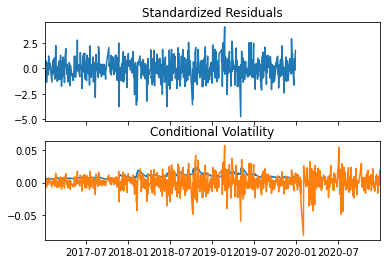

In [19]:
#plot the conditional variance generated by GARCH(1,1)
res.plot()
plt.plot(daily300['LogReturn'])

In [20]:
res.params

mu          0.000614
omega       0.000003
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [21]:
#Forecasting VaR
forecasts = res.forecast(start='2020-01-01', reindex = True )
cond_mean = forecasts.mean["2020":]
cond_var = forecasts.variance["2020":]
test = daily300.loc['2020':,'LogReturn']
cvar = np.array(cond_var).squeeze()
std_rets = (test - res.params["mu"]) / np.sqrt(cvar)
std_rets

TradeDate
2020-01-02    1.418508
2020-01-03   -0.272363
2020-01-06   -0.521879
2020-01-07    0.819777
2020-01-08   -1.373788
                ...   
2020-12-25    0.835094
2020-12-28    0.427536
2020-12-29   -0.561125
2020-12-30    1.433288
2020-12-31    1.727960
Name: LogReturn, Length: 243, dtype: float64

In [22]:
forecasts.variance["2019-12-30":]

,h.1
TradeDate,
2019-12-30,NaN
2019-12-31,NaN
2020-01-02,0.000082
2020-01-03,0.000076
2020-01-06,0.000071
...,...
2020-12-25,0.000086
2020-12-28,0.000080
2020-12-29,0.000075


In [23]:
#计算Parametric VaR
value_at_risk_G_25 = cond_mean.values + np.sqrt(cond_var).values * (-1.96)
value_at_risk_G_50 = cond_mean.values + np.sqrt(cond_var).values * (-1.64)
value_at_risk_G = np.hstack([value_at_risk_G_25,value_at_risk_G_50])
value_at_risk_G = pd.DataFrame(value_at_risk_G, columns=["2.5%", "5%"], index=cond_var.index)
value_at_risk_G

,2.5%,5%
TradeDate,,
2020-01-02,-0.017184,-0.014278
2020-01-03,-0.016435,-0.013652
2020-01-06,-0.015909,-0.013212
2020-01-07,-0.015758,-0.013085
2020-01-08,-0.016788,-0.013947
...,...,...
2020-12-25,-0.017571,-0.014602
2020-12-28,-0.016891,-0.014033
2020-12-29,-0.016371,-0.013598


In [24]:
#计算empirical分位数
q_E = std_rets.quantile([0.025, 0.05])
print(q_E)
value_at_risk_E = cond_mean.values + np.sqrt(cond_var).values * q_E.values[None, :]
value_at_risk_E = pd.DataFrame(value_at_risk_E, columns=["2.5%", "5%"], index=cond_var.index)
value_at_risk_E

0.025   -1.978121
0.050   -1.638211
Name: LogReturn, dtype: float64


,2.5%,5%
TradeDate,,
2020-01-02,-0.017348,-0.014262
2020-01-03,-0.016593,-0.013636
2020-01-06,-0.016062,-0.013196
2020-01-07,-0.015910,-0.013070
2020-01-08,-0.016949,-0.013931
...,...,...
2020-12-25,-0.017740,-0.014586
2020-12-28,-0.017052,-0.014017
2020-12-29,-0.016528,-0.013583


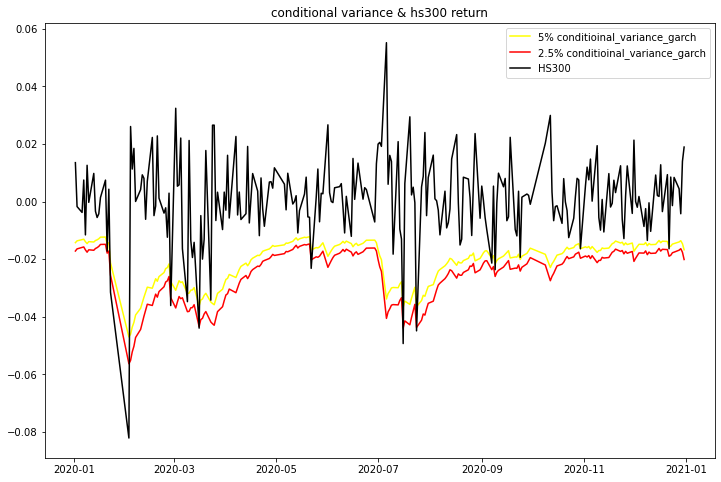

In [25]:
#展示hs300 2020年实际对数收益分布，基于garch预测的VaR线（红色2.5%，黄色5%）
fig = plt.figure(figsize=(12, 8))
VaR50_GARCH = plt.plot(value_at_risk_G['5%'], color='yellow', label='5% conditioinal_variance_garch')
VaR25_GARCH = plt.plot(value_at_risk_G['2.5%'], color='red', label='2.5% conditioinal_variance_garch')
#VaR50_E = plt.plot(value_at_risk_E['5%'], color='blue', label='5% conditioinal_variance_e')  
#VaR25_E = plt.plot(value_at_risk_E['2.5%'], color='green', label='2.5% conditioinal_variance_e')
rhs300 = plt.plot(daily300.loc['2020':,'LogReturn'], color='black', label = 'HS300')
plt.legend(loc='best')
plt.title('conditional variance & hs300 return')
plt.show()
#基于garch的线更向外，基于实际分布的更向内，基于GARCH的预测波动更大
#对于不同的分布，VaR2.5%的线比VaR5%的线更向外，与实际效果一致

## 使用minute300 计算已实现波动率

In [26]:
minute300['TradeDay'] = minute300['TradeTime'].str[:10]
minute300['LogReturn'] = (minute300['LogReturn'])**2
RV = minute300.groupby('TradeDay').sum('LogReturn')

In [27]:
RV.LogReturn.mean()

0.00019539105730214241

## 使用option300 计算隐含波动率

In [28]:
from scipy import stats
 
def blsprice(price, strike, rate, time, volatility):#price标的资产市场价格，strike执行价格，rate无风险利率
#     time距离到期时间，volatility标的资产价格波动率，call：call option（看涨期权）价格，put：put option（看跌期权）价格
    price, strike, rate, time, volatility = float(price), float(strike), float(rate), float(time), float(volatility)
    d1 = (np.log(price / strike) + (rate + 0.5 * volatility ** 2) * time) / (volatility * np.sqrt(time))
    d2 = d1 - volatility * np.sqrt(time)
    
    call = price * stats.norm.cdf(d1, 0.0, 1.0) - strike * np.exp(-rate * time) * stats.norm.cdf(d2, 0.0, 1.0)
    put = strike * np.exp(-rate * time) * stats.norm.cdf(-d2, 0.0, 1.0) - price * stats.norm.cdf(-d1, 0.0, 1.0) 
    
    return call, put

def ImpliedVolatitityCallObj(call, Price, Strike, Rate, Time, volatility_est=0.1):
#volatility_est预期的标的资产价格波动率
    def difference(volatility_est, Price, Strike, Rate, Time):
        # 根据参数,使用blsprice计算期权价格 定义函数
        est_call = blsprice(Price, Strike, Rate, Time, volatility_est)[0]
        return est_call - call
    # 存在一个波动率使得下列等式成立，解函数difference，寻找最佳volatility
    iv = fsolve(difference, volatility_est, args=(Price, Strike, Rate, Time))[0]
    
    return iv #iv隐含波动率


def ImpliedVolatitityPutObj(put, Price, Strike, Rate, Time, volatility_est=0.1):
    def difference(volatility_est, Price, Strike, Rate, Time):
        # 根据参数,使用blsprice计算期权价格
        est_put = blsprice(Price, Strike, Rate, Time, volatility_est)[1]
        return est_put - put
    # 存在一个波动率使得下列等式成立
    iv = fsolve(difference, volatility_est, args=(Price, Strike, Rate, Time))[0]
    
    return iv

# 函数求解
from scipy.optimize import fsolve
 
Price =4152.24
Strike = 4600
Rate = 0.024091
Time = 0.964481
Cm = 768.8
print ('Implied Volatitity of Call =', ImpliedVolatitityCallObj(Cm, Price, Strike, Rate, Time)/np.sqrt(243))
#print( 'Implied Volatitity of Put =', ImpliedVolatitityPutObj(Pm, Price, Strike, Rate, Time))

Implied Volatitity of Call = 0.035672845091187726


In [29]:
import datetime  

def third_friday(year, month):
    """Return datetime.date for monthly option expiration given year and
    month
    """
    # The 15th is the lowest third day in the month
    third = datetime.date(year, month, 15)
    # What day of the week is the 15th?
    w = third.weekday()
    # Friday is weekday 4
    if w != 4:
        # Replace just the day (of month)
        third = third.replace(day=(15 + (4 - w) % 7))
    return str(third)

In [30]:
option300['Maturity'] = pd.to_datetime(option300['Maturity'])

In [31]:
option300['T'] = (option300['Maturity'] - pd.to_datetime(option300['TradingDate'])).astype('timedelta64[D]').astype(float)/366
           

In [32]:
option300 = pd.read_csv(r'C:\apache\jupyter\data\option300.csv')
option300.drop(option300.columns[[1, 2]], axis=1, inplace=True) 
option300.index = pd.to_datetime(option300['TradingDate'])
option300['DueYear'] = pd.to_numeric('20'+option300['Maturity'].astype('str').str[:2])
option300['DueMonth'] = pd.to_numeric(option300['Maturity'].astype('str').str[-2:])

for row in option300.index:
    option300['Maturity'][row] = third_friday(option300['DueYear'][row],option300['DueMonth'][row])
    
option300['Maturity'] = pd.to_datetime(option300['Maturity']) 
option300['R'] = RisklessReturn['RisklessReturn'].sum()
option300['S'] = daily300['ClosePrice']
option300['T'] = (option300['Maturity'] - pd.to_datetime(option300['TradingDate'])).astype('timedelta64[D]').astype(float)/366
option300['ImpliedV'] = 0.0
option300 = option300.dropna()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [33]:
option300

,TradingDate,Symbol,CallOrPut,SettlePrice,Volume,Position,Amount,Year,Maturity,K,DueYear,DueMonth,R,S,T,ImpliedV
TradingDate,,,,,,,,,,,,,,,,
2020-01-02,2020-01-02,IO2002-C-4000,C,221.0,2240,1886,50078340,2020,2020-02-21,4000,2020,2,0.024091,4152.24,0.136612,0.0
2020-01-03,2020-01-03,IO2002-C-4200,C,95.0,1408,1055,14767460,2020,2020-02-21,4200,2020,2,0.024091,4144.96,0.133880,0.0
2020-01-06,2020-01-06,IO2002-C-4000,C,198.2,2164,2015,46025300,2020,2020-02-21,4000,2020,2,0.024091,4129.30,0.125683,0.0
2020-01-07,2020-01-07,IO2002-C-4000,C,216.6,1904,2058,40846160,2020,2020-02-21,4000,2020,2,0.024091,4160.23,0.122951,0.0
2020-01-08,2020-01-08,IO2002-C-4000,C,183.6,1635,2067,32059400,2020,2020-02-21,4000,2020,2,0.024091,4112.32,0.120219,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,2020-12-25,IO2101-C-5000,C,107.8,9050,6896,88291820,2020,2021-01-15,5000,2021,1,0.024091,5042.01,0.057377,0.0
2020-12-28,2020-12-28,IO2101-C-5100,C,67.4,10790,7386,75475980,2020,2021-01-15,5100,2021,1,0.024091,5064.41,0.049180,0.0
2020-12-29,2020-12-29,IO2101-C-5100,C,60.8,9666,7976,65754520,2020,2021-01-15,5100,2021,1,0.024091,5042.94,0.046448,0.0


In [34]:
#call, Price, Strike, Rate, Time, volatility_est=0.1
for row in option300.index:
    option300['ImpliedV'][row] = ImpliedVolatitityCallObj(option300['SettlePrice'][row],option300['S'][row],option300['K'][row],option300['R'][row],option300['T'][row])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [35]:
result = pd.DataFrame(list(zip( np.sqrt(cond_var['h.1']), option300['ImpliedV']/np.sqrt(243), np.sqrt(RV['LogReturn']) )),
                      columns = ['CondVar','ImpliedV','RealizedV'])
result.index = option300.index

In [36]:
result[result.ImpliedV>0].describe()

,CondVar,ImpliedV,RealizedV
count,241.000000,241.000000,241.000000
mean,0.013074,0.013372,0.011407
std,0.004616,0.005373,0.008087
min,0.007825,0.000115,0.004346
25%,0.009450,0.010257,0.007311
50%,0.011363,0.012753,0.009324
75%,0.016458,0.015920,0.012820
max,0.029037,0.035949,0.096534


In [37]:
stats.jarque_bera(result.RealizedV)

Jarque_beraResult(statistic=29558.764355681076, pvalue=0.0)

In [38]:
result.to_csv(r'C:\apache\jupyter\data\result.csv')

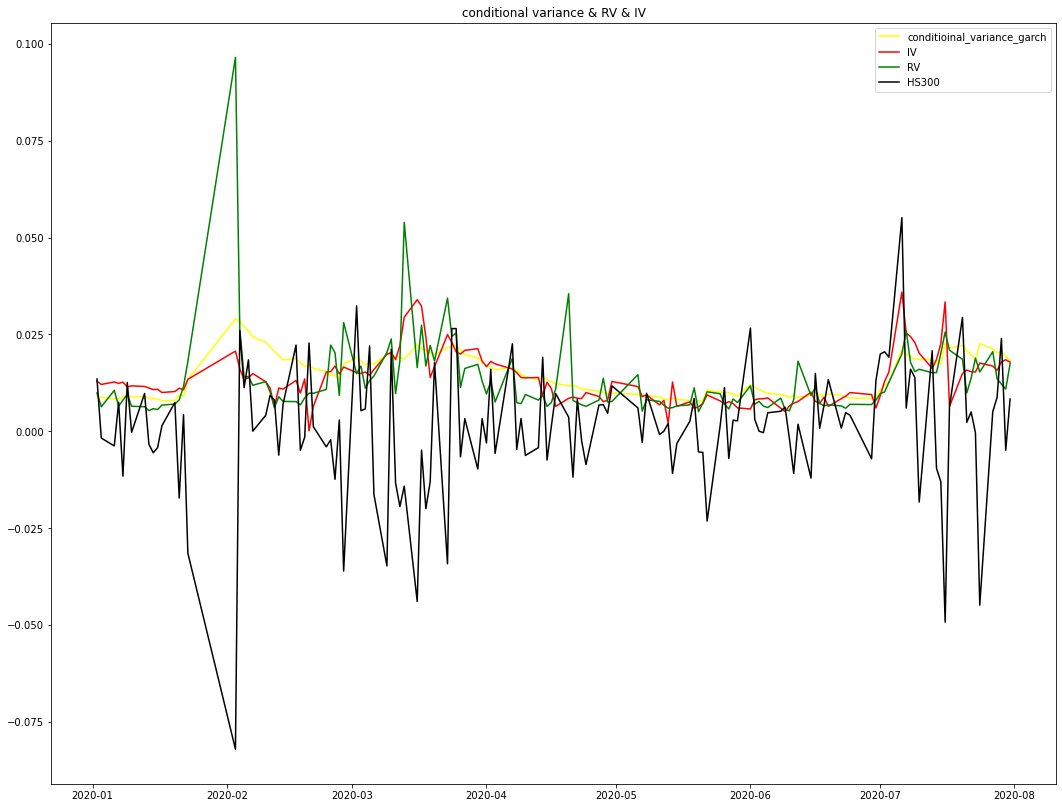

In [47]:

fig = plt.figure(figsize=(18, 14))
plt.plot(result.loc['2020-01-01':'2020-07-31','CondVar'], color='yellow', label= 'conditioinal_variance_garch')
plt.plot(result.loc['2020-01-01':'2020-07-31','ImpliedV'][result.ImpliedV>0], color='red', label= 'IV')
plt.plot(result.loc['2020-01-01':'2020-07-31','RealizedV'], color='green', label= 'RV')
plt.plot(daily300.loc['2020-01-01':'2020-07-31','LogReturn'], color='black', label = 'HS300')
plt.legend(loc='best')
plt.title('conditional variance & RV & IV')
plt.show()

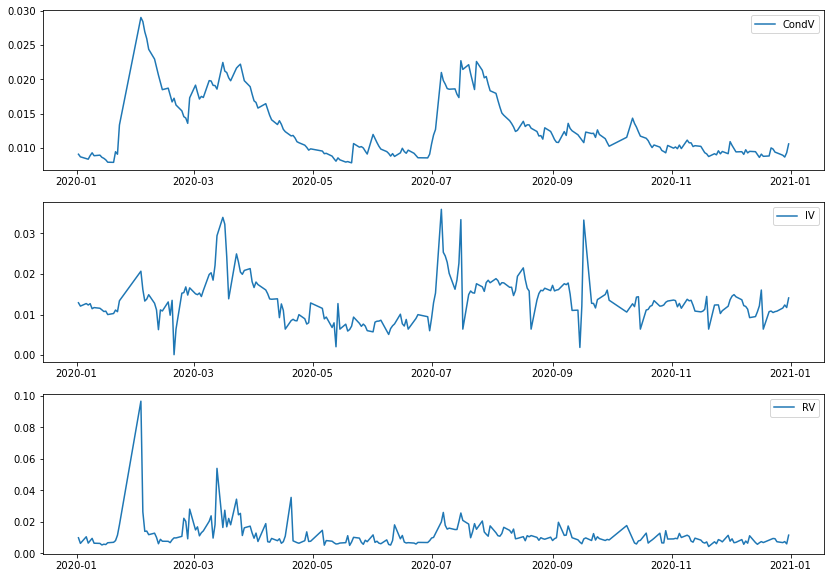

In [128]:
plt.figure(figsize=(14,10))
plt.subplot(311)
plt.plot(result.loc['2020-01-01':'2020-12-31','CondVar'],label = 'CondV')
plt.legend()
plt.subplot(312)
plt.plot(result.loc['2020-01-01':'2020-12-31','ImpliedV'][result.ImpliedV>0],label='IV')
plt.legend()
plt.subplot(313)
plt.plot(result.loc['2020-01-01':'2020-12-31','RealizedV'],label='RV')
plt.legend(loc=0)